<a href="https://colab.research.google.com/github/sahandfrd94/Image-classificqation-by-Transfer-Learning-/blob/main/Image_classify_by_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import dataset from kaggle

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d sanikamal/horses-or-humans-dataset

Saving kaggle.json to kaggle.json
ref                                                         title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
hummaamqaasim/jobs-in-data                                  Jobs and Salaries in Data Science            76KB  2023-12-25 20:03:32           4917         88  1.0              
nextmillionaire/car-accident-dataset                        Car Accident Dataset                          7MB  2024-01-10 23:04:21            597         24  0.88235295       
thedrcat/daigt-v2-train-dataset                             DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           4034        314  1.0              
jacksondivakarr/car-crash-dataset                           Car Crash Dataset         

In [2]:
import zipfile

zip_ref = zipfile.ZipFile('/content/horses-or-humans-dataset.zip', 'r')
zip_ref.extractall('Dataset')

#Data Augmentaion

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_augmentor = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip=True
)
test_augmentor = ImageDataGenerator(
    rescale = 1/255
)

In [4]:
train_generator = train_augmentor.flow_from_directory(
    '/content/Dataset/horse-or-human/train',
    batch_size = 64,
    class_mode = 'binary',
    target_size = (160,160)
)

test_generator = test_augmentor.flow_from_directory(
    '/content/Dataset/horse-or-human/validation',
    batch_size = 64,
    class_mode = 'binary',
    target_size = (160,160)
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


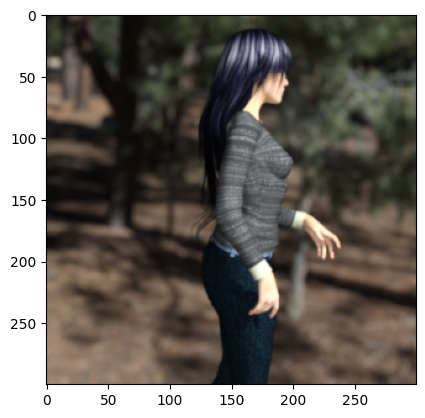

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread('/content/Dataset/horse-or-human/train/humans/human02-28.png')[:,:,::-1]
plt.imshow(img)
plt.show()

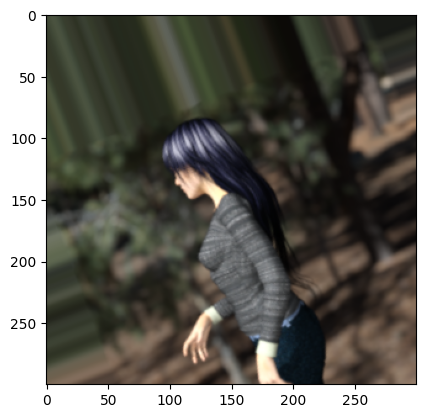

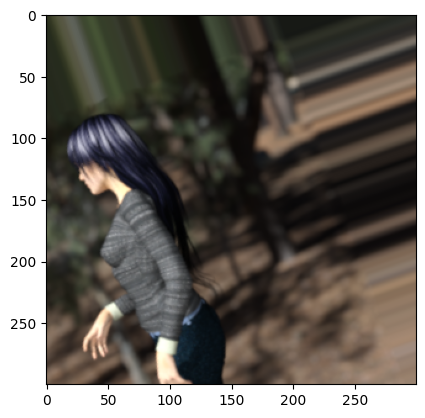

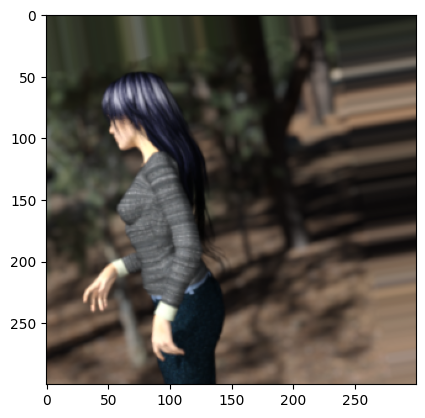

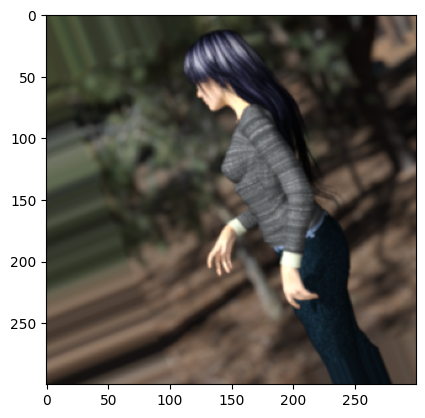

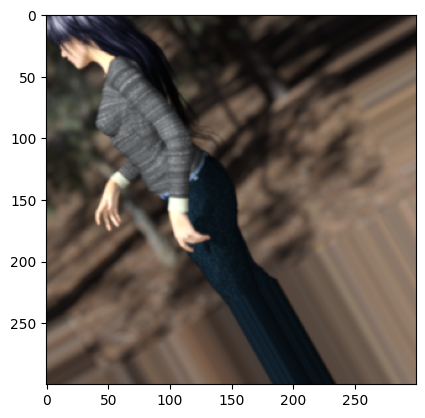

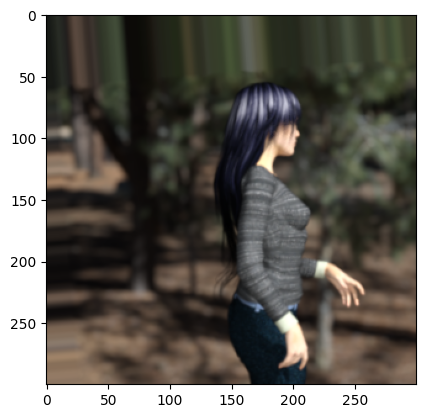

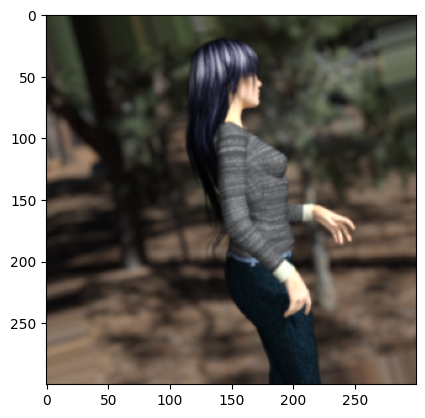

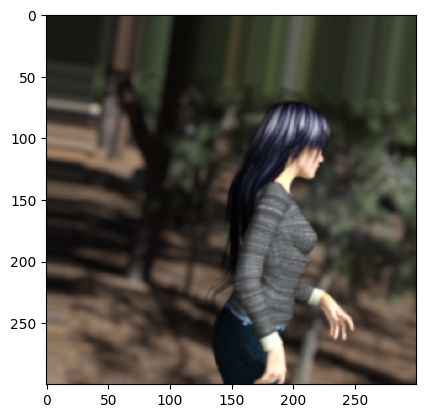

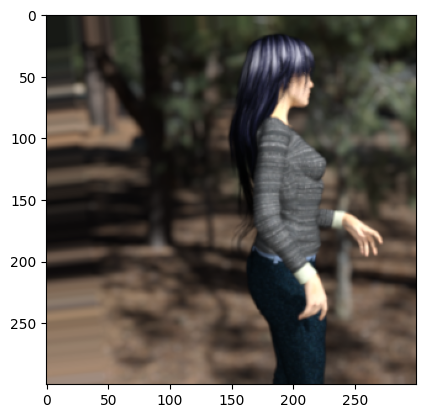

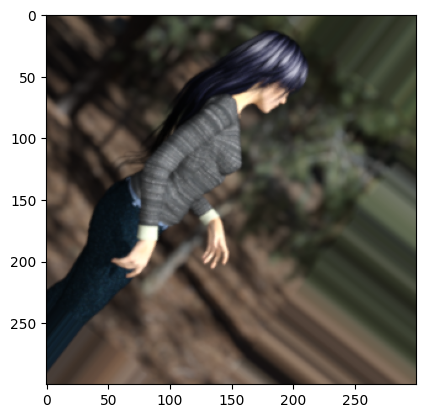

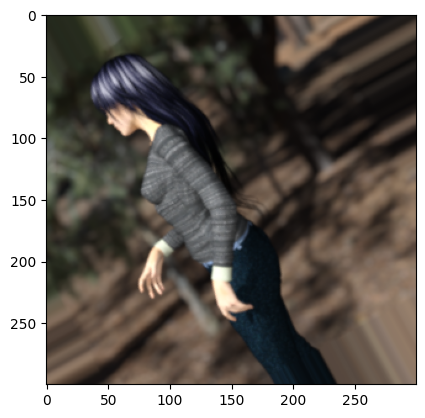

In [6]:
i = 0
img = np.expand_dims(img, axis = 0)

for batch in train_augmentor.flow(img , batch_size=1):
  plt.imshow(batch[0])
  plt.show()
  i = i+1
  if i > 10 :
    break

# Import MobileNetV2


In [7]:
from tensorflow.keras.applications import MobileNetV2
TL_model  = MobileNetV2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (160,160,3),
    pooling = max
)

9406464/9406464 [==============================] - 0s 0us/step


In [8]:
TL_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

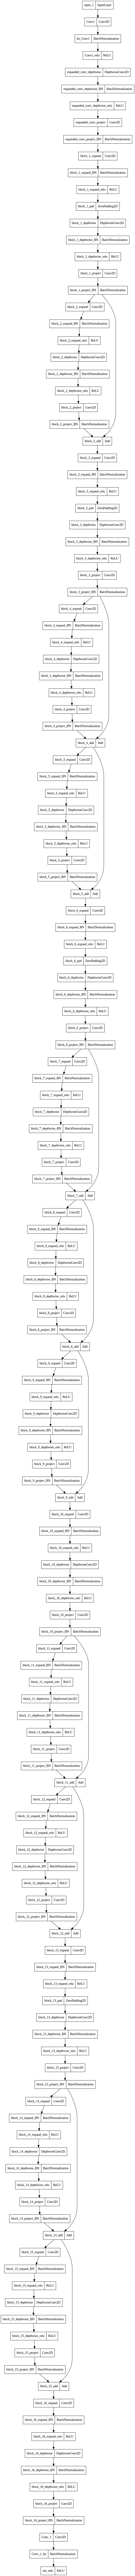

In [9]:
from keras.utils import plot_model
plot_model(TL_model)

In [10]:
for layer in TL_model.layers:
  layer.trainable = False

In [11]:
TL_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [12]:
last_layer= TL_model.get_layer('out_relu')
last_output = last_layer.output

# connect backbone to fully connected layers

In [13]:
from keras.layers import Dense,Flatten,Dropout
x = Flatten()(last_output)
x = Dense(64,'relu')(x)
x = Dropout(0.2)(x)
out_x = Dense(1,'sigmoid')(x)

In [14]:
from keras.models import Model
imageclassifier = Model(TL_model.input , out_x)

In [16]:
from tensorflow.keras.optimizers import  Adam
imageclassifier.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'],
)

#Create model Checkpoint




In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint(
    filepath = '/content/models/best.h5',
    monitor = 'val_accuracy',
    save_weights_only = False,
    save_best_only = True,
    verbose = 1
)